In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pairs = pd.read_csv("data/final/pairs.csv")

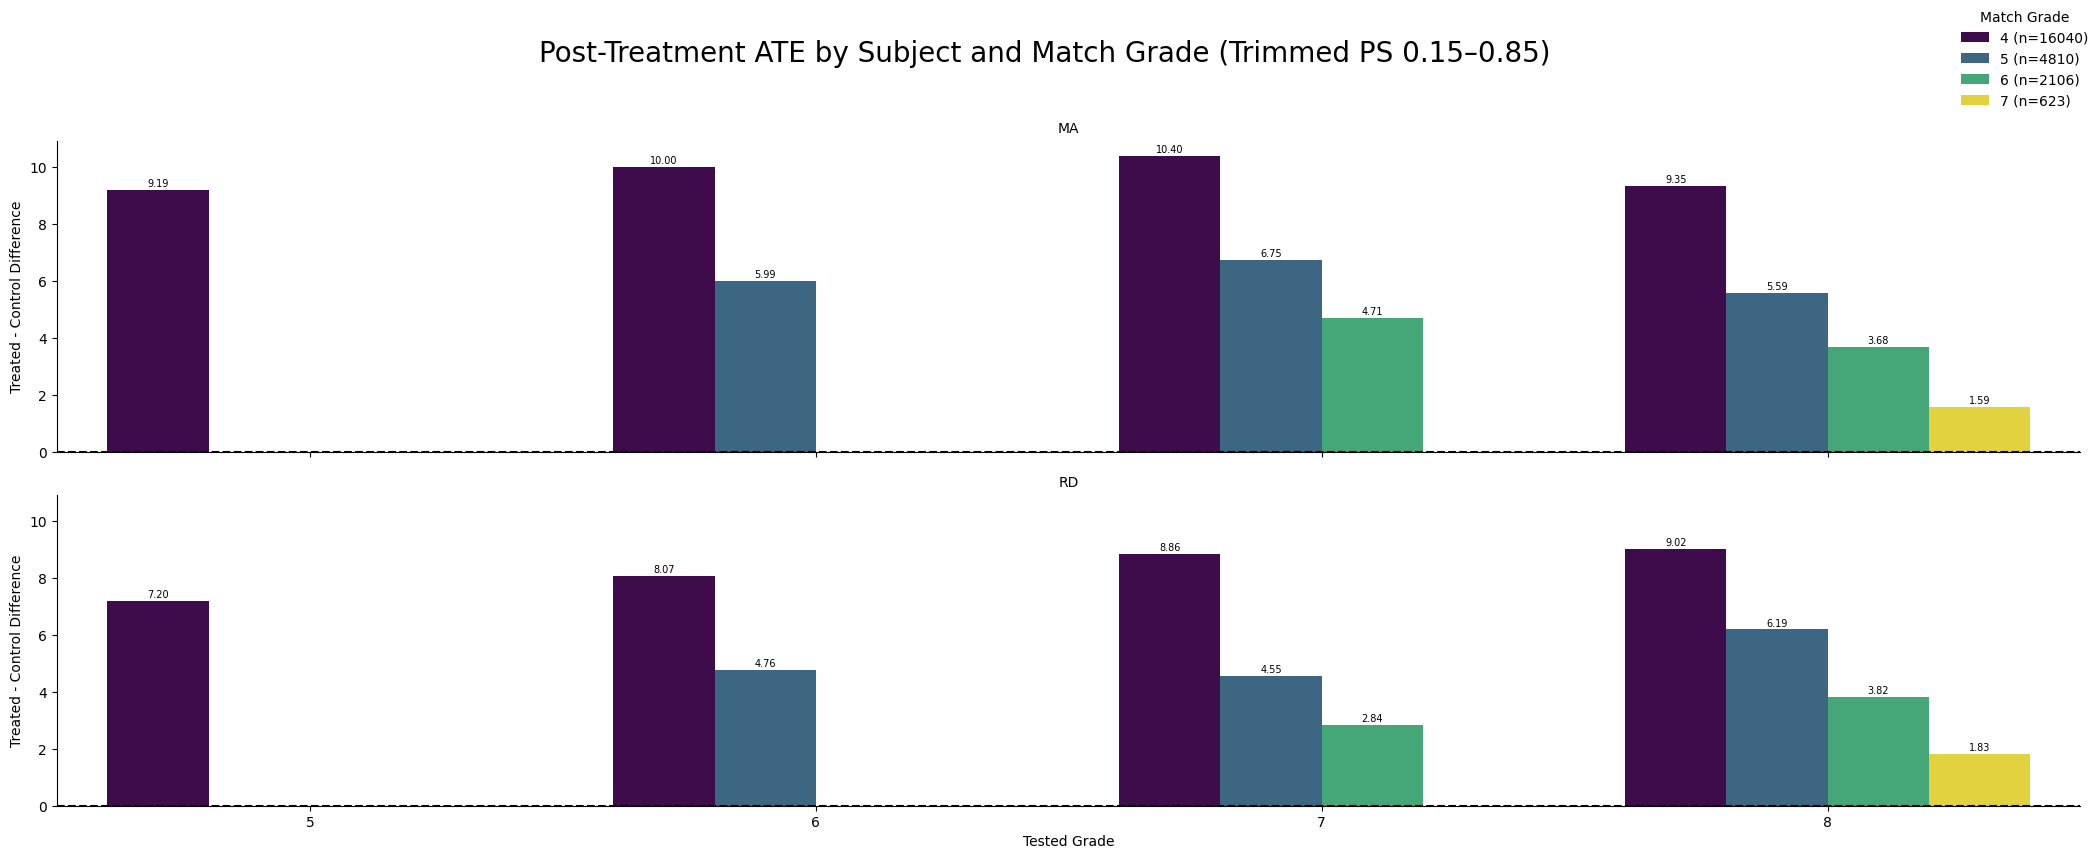

In [10]:
#ATEs by grade
from scipy.stats import ttest_ind

gifted_grades = list(range(4, 9))  # Grades 4–8
post_effects_trimmed = []

# Loop through each match grade cohort
for grade in gifted_grades:
    df_g = pairs[pairs['match_grade'] == grade].copy()
    if df_g.empty:
        continue

    test_cols = [col for col in df_g.columns if col.startswith(('MA', 'RD'))]
    post_cols = [col for col in test_cols if int(col.split('0')[1]) > grade]

    for col in sorted(post_cols, key=lambda x: int(x.split('0')[1])):
        means = df_g.groupby('treatment')[col].mean()
        n = df_g.groupby('treatment')[col].count()

        tstat, pval = ttest_ind(
            df_g[df_g['treatment'] == 1][col],
            df_g[df_g['treatment'] == 0][col],
            nan_policy='omit'
        )

        post_effects_trimmed.append({
            'match_grade': grade,
            'score_col': col,
            'treated_mean': means.get(1, float('nan')),
            'control_mean': means.get(0, float('nan')),
            'difference': means.get(1, float('nan')) - means.get(0, float('nan')),
            'treated_n': n.get(1, 0),
            'control_n': n.get(0, 0),
            'p_value': pval
        })

# Create a summary DataFrame
effects_trimmed_df = pd.DataFrame(post_effects_trimmed)
effects_trimmed_df = effects_trimmed_df.sort_values(by=['match_grade', 'score_col'])

# Extract subject and grade from score_col for plotting
effects_trimmed_df['subject'] = effects_trimmed_df['score_col'].apply(lambda x: x.split('0')[0])
effects_trimmed_df['score_grade'] = effects_trimmed_df['score_col'].apply(lambda x: int(x.split('0')[1]))

# Make a copy to work with
viz_df = effects_trimmed_df.copy()

# Initialize FacetGrid with vertical layout
g = sns.FacetGrid(
    viz_df,
    row="subject",
    sharey=True,
    height=4,
    aspect=5
)

# Draw grouped bars in each facet
g.map_dataframe(
    sns.barplot,
    x='score_grade',
    y='difference',
    hue='match_grade',
    palette='viridis',
    dodge=True
)

# Add horizontal line and annotations
for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--')
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + (0.05 if height >= 0 else -0.15),
                f'{height:.2f}',
                ha='center',
                va='bottom' if height >= 0 else 'top',
                fontsize=7
            )


# Clean up plot
g.set_titles("{row_name}")
g.set_axis_labels("Tested Grade", "Treated - Control Difference")


# Compute total n for each match_grade
n_by_grade = viz_df.groupby("match_grade")["treated_n"].max().to_dict()
# ^ use max() because within a match_grade all rows should have the same n

# After g.add_legend()
g.add_legend(title="Match Grade")

# Update legend labels to include n
new_labels = [f"{lab.get_text()} (n={n_by_grade[int(lab.get_text())]})"
              for lab in g._legend.texts]

for text_obj, new_text in zip(g._legend.texts, new_labels):
    text_obj.set_text(new_text)

# Move legend if you want
g._legend.set_bbox_to_anchor((1, 1))



plt.suptitle("Post-Treatment ATE by Subject and Match Grade (Trimmed PS 0.15–0.85)", fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

